In [1]:
"""Evaluate best trained checkpoint on dev set in NEWS"""
import os, sys
import ujson as json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import utils
import train

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from tqdm import tqdm
from transformers import DistilBertModel, AlbertModel
from args import get_train_args
from models import DistilBERT, ALBERT
from utils import NEWS, collate_fn

%load_ext autoreload
%autoreload 2

In [2]:
"""Utility methods"""
def get_model(args, device):
    if args.name == 'DistilBERT':
        model = DistilBERT
    elif args.name == 'ALBERT':
        model = ALBERT
        
    model = model(args.hidden_size, args.num_labels,
                  drop_prob=args.drop_prob,
                  freeze=args.freeze,
                  use_img=args.use_img,
                  img_size=args.img_size)
    model = nn.DataParallel(model, args.gpu_ids)
    model = model.to(device)
    
    return model

def get_data_loader(args, record_file):
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    dataset = NEWS(record_file, transform=transform)
    data_loader = data.DataLoader(dataset,
                                  batch_size=args.batch_size,
                                  shuffle=False,
                                  num_workers=args.num_workers,
                                  collate_fn=collate_fn)
    
    return data_loader

In [3]:
"""Get F1 score of a model"""
def get_models_F1(args):
    device, args.gpu_ids = utils.get_available_devices()

    model = get_model(args, device)
    data_loader = get_data_loader(args, args.dev_record_file)
    
    base_dir = './save/train/'
    for ckpt_dir in os.listdir(base_dir):
        if args.name in ckpt_dir:
            checkpoint_path = os.path.join(base_dir, ckpt_dir, 'best.pth.tar')
            ckpt_dict = torch.load(checkpoint_path, map_location=device)
            
            # Build model, load parameters
            model.load_state_dict(ckpt_dict['model_state'])
            
            # Evaluate
            results, _ = train.evaluate(model, data_loader, device)
            print(f'{ckpt_dir}: F1 {results["F1"]:.2f}')

name = 'ALBERT'
use_img = 'False'
dev_record_file = './data/dev_ALBERT.npz'
batch_size = '8'
sys.argv = ['args.py', '--name', name,
            '--use_img', use_img,
            '--dev_record_file', dev_record_file,
            '--batch_size', batch_size]
get_models_F1(get_train_args())

  0%|          | 0/277 [00:00<?, ?it/s]

ALBERT-10: F1 82.91


  0%|          | 0/277 [00:00<?, ?it/s]

ALBERT-04: F1 81.19


  0%|          | 0/277 [00:00<?, ?it/s]

ALBERT-01: F1 82.04


  0%|          | 0/277 [00:00<?, ?it/s]

ALBERT-07: F1 6.91


  0%|          | 0/277 [00:00<?, ?it/s]

ALBERT-06: F1 82.12


  0%|          | 0/277 [00:00<?, ?it/s]

ALBERT-02: F1 78.38


  0%|          | 0/277 [00:00<?, ?it/s]

ALBERT-11: F1 72.94


  0%|          | 0/277 [00:00<?, ?it/s]

ALBERT-03: F1 80.52


  0%|          | 0/277 [00:00<?, ?it/s]

ALBERT-08: F1 14.42


  0%|          | 0/277 [00:00<?, ?it/s]

ALBERT-05: F1 78.11


100%|██████████| 277/277 [00:06<00:00, 43.94it/s, NLL=0.386]

ALBERT-09: F1 78.61


100%|██████████| 278/278 [00:03<00:00, 78.67it/s, NLL=0.336]


DistilBERT-26: F1 83.61


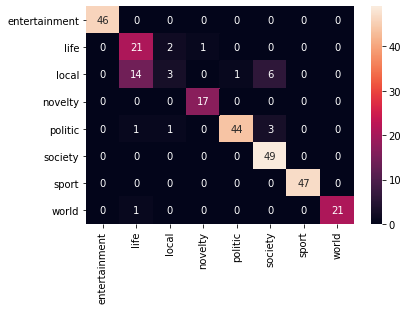

2333 prediction: life       true: local     
4378 prediction: society    true: politic   
2285 prediction: life       true: local     
2513 prediction: life       true: local     
2127 prediction: life       true: local     
2295 prediction: life       true: local     
2514 prediction: politic    true: local     
2185 prediction: society    true: local     
2269 prediction: life       true: local     
2445 prediction: society    true: local     
2264 prediction: life       true: local     
1367 prediction: local      true: life      
2312 prediction: life       true: local     
 309 prediction: society    true: politic   
1268 prediction: local      true: life      
4553 prediction: society    true: politic   
2229 prediction: society    true: local     
1253 prediction: novelty    true: life      
2328 prediction: society    true: local     
 271 prediction: local      true: politic   
2378 prediction: life       true: local     
2415 prediction: life       true: local     
2294 predi

In [3]:
"""Analyze model with confusion matrix then print out the incorrect predictions"""
def model_predict(args, ckpt_dir, record_file):
    # Set up device, model, data_loader
    device, args.gpu_ids = utils.get_available_devices()
    model = get_model(args, device)
    data_loader = get_data_loader(args, record_file)
    
    # load model
    ckpt_path = os.path.join(args.save_dir, 'train', ckpt_dir, 'best.pth.tar')
    ckpt_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt_dict['model_state'])
            
    # Evaluate
    results, pred_dict = train.evaluate(model, data_loader, device)
    print(f'{ckpt_dir}: F1 {results["F1"]:.2f}')

    return pred_dict

def plot_confusion_matrix(pred_dict):
    y_pred, y_true =  zip(*pred_dict.values())
    cm = confusion_matrix(y_true, y_pred)
    with open('./data/cat2idx.json', 'r') as fh:
        cat2idx = json.load(fh)
    labels = [label[0] for label in sorted(cat2idx.items(), key=lambda x: x[1])]
#     sns.set(rc={'figure.figsize':(10, 7)},
#             font_scale=1.4)
    sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
    plt.show()
    
    return cat2idx

def print_wrong_pred(pred_dict):
    incorrect_idxs = [idx for idx, result in pred_dict.items() if result[0] != result[1]]
    idx2cat = {idx: cat for cat, idx in cat2idx.items()}

    for idx in incorrect_idxs:
        pred_label = idx2cat[pred_dict[idx][0]]
        true_label = idx2cat[pred_dict[idx][1]]
        print(f'{idx:4d} prediction: {pred_label:10s} true: {true_label:10s}')

name = 'DistilBERT'
use_img = 'False'
record_file = './data/test.npz'
sys.argv = ['args.py', '--name', name,
            '--use_img', use_img]
ckpt_dir = 'DistilBERT-26'
pred_dict = model_predict(get_train_args(), ckpt_dir, record_file)
cat2idx = plot_confusion_matrix(pred_dict)
print_wrong_pred(pred_dict)

Date      : 2020-04-02

URL       : https://news.ltn.com.tw/news/NewTaipei/paper/1363063

Title     : 搭車戴口罩 中央：有法源的應變措施

Context   : 〔記者何玉華、邱書昱、林欣漢、吳正庭／綜合報導〕從昨天起，搭乘大眾運輸工具都要戴口罩、測量體溫，新北市、基隆市各火車站等大眾運輸站點，首日實施的秩序良好，絕大多數民眾都配合防疫；新北市長侯友宜建議中央，口罩購買應放寬為「十四天購買十片」，先給足夠才能強制要求民眾配戴，中央要求保持社交距離、搭乘大眾運輸要戴口罩缺乏法源依據，希望公告法源及相關罰則，以利地方政府執行。指揮官陳時中及交通部均表示，無法維持社交距離時，一定要配戴口罩的做法，是依據「嚴重特殊傳染性肺炎防治及紓困振興特別條例」與傳染病防治法第七條規定，指揮官為防治控制疫情需要，得實施必要的應變處置或措施，並非無法源依據。疾管署副署長莊人祥補充說明，傳染病防治法第七條規定，主管機關應實施各項調查及有效預防措施，以防止傳染病發生；傳染病已發生或流行時，應儘速控制，防止其蔓延。新北市樹林火車站是東部幹線列車的起訖點，運量大、人潮多，站務人員表示，架設紅外線體溫量測儀，加快量測的時間以免壅塞，少數民眾未戴口罩進站，勸導提醒後都能配合；板橋車站的高鐵、台鐵出入口也設有紅外線體溫量測儀，民眾進出順暢，少數因攜帶便當、熱飲或體溫略高的民眾，被引導到一旁測量額溫。基隆火車站發生多件紅外線檢測儀感應到體溫過高的情況，原來是民眾身上帶的包子、麵線、熱咖啡等，都被工作人員攔下測量額溫，確定沒有異常才能進站；無人車站的暖暖火車站及八斗子火車站，台鐵加派站務人員用額溫槍測量乘客的體溫，為防疫嚴格把關。新北市府昨天召開防疫暨市政會議，交通局長鍾鳴時表示，按照目前的公車定型化契約，業者拒載的條件只有在傳染病確定，或妨害其他乘客的搭乘權益，並沒有規範戴口罩，萬一有乘客拒戴口罩且堅持搭公車，業者拒載的法源依據不足。侯友宜表示，中央要求保持社交距離、搭乘大眾運輸要戴口罩，地方政府會配合執行，但如果沒有強制力也只能勸導，希望中央盡速公布法源依據並訂定罰則，且建議中央，口罩購買應放寬為「十四天購買十片」。新莊區長朱思戎反映說，一名居家檢疫的對象到醫院採檢後自行返家，隔了兩天才確診，返家路線

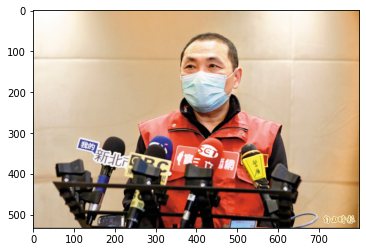

True label: local

Prediction: life


In [6]:
"""Get article by idx"""
def get_article(idx, pred_label):
    raw_context = np.load('./data/train_raw.npz', allow_pickle=True)['liberty']
    news = raw_context[raw_context[:, 6]==idx]
    date, title, context, img_path, true_label, url, _ = list(*news)
    date = date.strftime('%Y-%m-%d')
    img = plt.imread(img_path)

    print(f'{"Date":10s}: {date}\n')
    print(f'{"URL":10s}: {url}\n')
    print(f'{"Title":10s}: {title}\n')
    print(f'{"Context":10s}: {context}\n')
    plt.imshow(img)
    plt.show()
    print(f'{"True label":10s}: {true_label}\n')
    print(f'{"Prediction":10s}: {pred_label}')

get_article(2378, 'life')

320it [00:03, 87.40it/s]                         


Contexture embedding


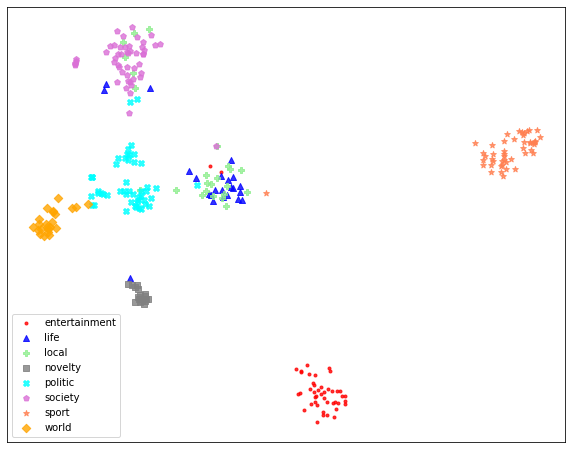

Image embedding


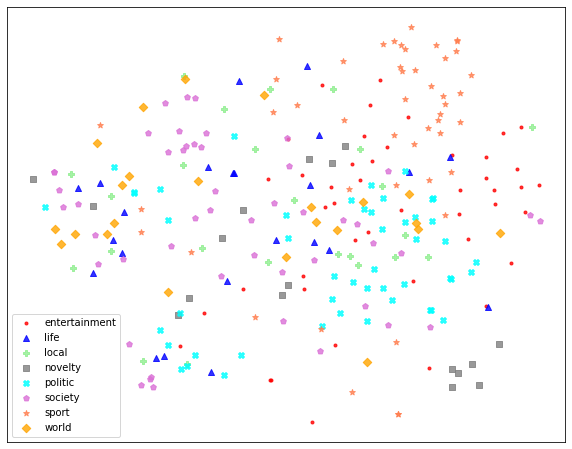

In [98]:
"""Plot embedding scatters"""
def plot_features(embs_r, labels, message):
    with open('./data/cat2idx.json', 'r') as fh:
        cat2idx = json.load(fh)
    idx2cat = {v: k for k, v in cat2idx.items()}

    markers = (".", "^", "P", "s", "X", "p", "*", "D")
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan', 'orchid', 'coral', 'orange')
    print(message)
    plt.figure(figsize=(10, 8))
    plt.tick_params(axis='both', which='both',    
                    bottom=False, left=False,
                    labelbottom=False, labelleft=False)
    for label in np.unique(labels):
        plt.scatter(embs_r[labels==label, 0], embs_r[labels==label, 1],
                    alpha=0.8, c=colors[label],
                    marker=markers[label], label=idx2cat[label])
    plt.legend()
    plt.show()
    
def get_img_contexture_plot(args, model, ckpt_dir, record_file):
   # Set up device, model, data_loader
    device, args.gpu_ids = utils.get_available_devices()
    model = get_model(args, device)
    ckpt_path = os.path.join(args.save_dir, 'train', ckpt_dir, 'best.pth.tar')
    ckpt_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt_dict['model_state'])
    if args.name == 'DistilBERT':
        bert = model.module.distilbert
    elif args.name == 'ALBERT':
        bert = model.module.albert
    resnet = model.module.resnet18
    
    data_loader = get_data_loader(args, record_file)
    
    con_embs = []
    img_embs = []
    labels = []
    with torch.no_grad(), tqdm(total=len(data_loader.dataset)) as progress_bar:
        for input_idxs, atten_masks, images, ids, y in data_loader:
            # Setup for forward
            input_idxs = input_idxs.to(device)
            atten_masks = atten_masks.to(device)
            images = images.to(device)
            
            con_emb = bert(input_ids=input_idxs,
                           attention_mask=atten_masks)[0][:, 0]
            img_emb = resnet(images).view(-1, args.img_size)
            con_embs += con_emb.tolist()
            img_embs += img_emb.tolist()
            labels += y.tolist()
            
            progress_bar.update(args.batch_size)
        
    con_embs_r = TSNE(n_components=2, random_state=args.seed).fit_transform(con_embs)
    img_embs_r = TSNE(n_components=2, random_state=args.seed).fit_transform(img_embs)
    labels = np.array(labels)
    
    plot_features(con_embs_r, labels, 'Contexture embedding')
    plot_features(img_embs_r, labels, 'Image embedding')

name = 'DistilBERT'
ckpt_dir = 'DistilBERT-25'
record_file = './data/dev.npz'
sys.argv = ['args.py', '--name', name]
get_img_contexture_plot(get_train_args(), ALBERT, ckpt_dir, record_file)

In [107]:
"""Get model information"""
def count_parameters(model):
    return sum([param.numel() for param in model.parameters() if param.requires_grad])

distilbert = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
albert = AlbertModel.from_pretrained('voidful/albert_chinese_base')
distilbert_params = count_parameters(distilbert)
albert_params = count_parameters(albert)
print('Parameters')
print(f'DistilBERT: {distilbert_params}')
print(f'ALBERT: {albert_params}')

Parameters
DistilBERT: 134734080
ALBERT: 10547968
